In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F


%matplotlib inline
import matplotlib.pyplot as plt

import re

import urllib.request

from tqdm import tqdm

In [2]:
!pip install transformers

#Higgingface import
from transformers import BertTokenizer, BertModel
# from transformers import AutoModel

#Hugginggece tokenizer/model load
bert_tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base") # 사전 토크나이저 로드
bert_model = BertModel.from_pretrained("beomi/kcbert-base") # 사전 학습모델 로드

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
#Tokenizer

print(bert_tokenizer.tokenize('지금 시간 새벽 3시, 기네스는 역시 맛있어!')) # 서브워드기반 토큰화 결과
print(bert_tokenizer.tokenize('나는 종로구청에 갔다.')) # 서브워드기반 토큰화 결과
print(bert_tokenizer('지금 시간 새벽 3시, 기네스는 역시 맛있어!'))  #input_ids, token_type_ids, attention_mask

['지금', '시간', '새벽', '3', '##시', ',', '기네', '##스는', '역시', '맛', '##있어', '!']
['나는', '종로', '##구', '##청', '##에', '갔다', '.']
{'input_ids': [2, 8001, 8485, 12866, 22, 4039, 15, 28057, 15299, 8294, 1306, 10566, 5, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


* input_ids : token들의 id 리스트(sequence of token id).

* token_type_ids : 각 token이 어떤 문장에 속하는지를 나타내는 리스트. BERT는 한 번에 두 문장(sentence A, sentence B)을 입력으로 받을 수 있는데, bert-base-uncased tokenizer는 sentence A에 속하는 token에는 0을, sentence B에 속하는 token에는 1을 부여한다.

* attention_mask : attention 연산이 수행되어야 할 token과 무시해야 할 token을 구별하는 정보가 담긴 리스트. bert-base-uncased tokenizer는 attention 연산이 수행되어야 할, 일반적인 token에는 1을 부여하고, padding과 같이 attention 연산이 수행될 필요가 없는 token들에는 0을 부여한다.

In [4]:
#Model
token = bert_tokenizer('지금 시간 새벽 3시, 기네스는 역시 맛있어!', return_tensors="pt") # retrun_tensors="pt" >> token을 tensor로 반환
print(token)
print(token['input_ids'].size()) # tensor 사이즈

model_output = bert_model(input_ids=token['input_ids'], token_type_ids=token['token_type_ids'], attention_mask=token['attention_mask'])

print(model_output.keys())
print(model_output['last_hidden_state'].size()) # 마지막 layer의 hidden state의 벡터값 사이즈(입력된 문장이 14개의 토큰으로 구성됨 > 14개의 토큰에 대한 벡터값이 768)
print(model_output['pooler_output'].size()) # CLS 토큰에 대한 벡터값 사이즈 (CLS : 문장시작을 표시하기 위한 토큰)

{'input_ids': tensor([[    2,  8001,  8485, 12866,    22,  4039,    15, 28057, 15299,  8294,
          1306, 10566,     5,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 14])
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 14, 768])
torch.Size([1, 768])


In [5]:
#네이버 뉴스리뷰 데이터 load

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

row_train_data = pd.read_table('ratings_train.txt')
row_test_data = pd.read_table('ratings_test.txt')

In [6]:
row_train_data # (150000, 3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [7]:
row_test_data # (50000, 3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [8]:
# 문장 기본 전처리

!pip install emoji==1.7.0
# AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'
# 위 에러로 인한 emoji 1.7.0 버전 설치
# emoji 2.0.0 이후 버전부터는 emoji.UNICODE_EMOJI 사용불가
!pip install soynlp

import re # 정규표현식 사용을 위한 라이브러리
import emoji # 이모지 처리를 위한 라이브러리
from soynlp.normalizer import repeat_normalize

'''
soynlp : 한국어 분석을 위한 코드로, 학습데이터를 이용하지 않으면서 데이터에 존재하는 단어를 찾거나, 문장을 단어열로 분해, 혹은 품사 판별을 할 수 있는 비지도학습 접근법을 지향
soynlp.normalizer : 대화 데이터, 댓글 데이터에 등장하는 반복되는 이모티콘의 정리 및 한글, 혹은 텍스트만 남기기 위한 함수를 제공
(예시) repeat_normalize('와하하하하하하하하하핫', n_repeats=2) >>> '와하하핫'
'''


emojis = ''.join(emoji.UNICODE_EMOJI.keys()) # emojis : emoji keys 값들을 공백없이 합쳐서 반환
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

# clean 함수 정의 : 문자열 정리 함수
def clean(x):
    x = pattern.sub(' ', x) # sub : 필요없는 문자들 한칸 공백으로 대체(substitute)
    x = url_pattern.sub('', x) # sub : 인터넷 주소 형태 문자 삭제
    x = x.strip() # strip : 문자열 앞뒤 공백 제거
    x = repeat_normalize(x, num_repeats=2) # 반복되는 문자에 한하여 2회 반복만 남겨놓고 나머지 문자열 삭제
    # (예시) repeat_normalize('와하하하하하하하하하핫', n_repeats=2) >>> '와하하핫'
    return x

In [9]:
train_label = torch.tensor(row_train_data['label']) # 학습데이터 label
test_label = torch.tensor(row_test_data['label']) # 시험데이터 label

In [10]:
train_data = [clean(str(x)) for x in row_train_data['document']] # 학습데이터 document 문자열 데이터에 clean 함수 적용
test_data = [clean(str(x)) for x in row_test_data['document']] # 시험데이터 document 문자열 데이터에 clean 함수 적용

# EDA

## 데이터 톺아보기

In [11]:
train_length = [len(x) for x in train_data] # 학습 데이터 각 행별 길이

In [12]:
len(train_length) # 학습 데이터 총 갯수
# 참고 : row_train_data 결과 : (150000, 3)

150000

TypeError: __init__() got an unexpected keyword argument 'nonposy'

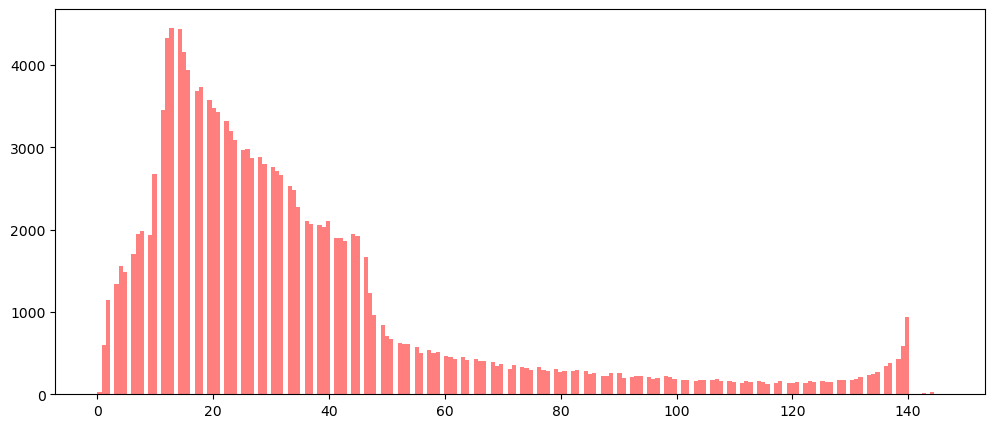

In [13]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))

# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')

# 그래프 제목
plt.title('Log-Histogram of length of review')

# 그래프 x 축 라벨
plt.xlabel('Length of review')

# 그래프 y 축 라벨
plt.ylabel('Number of review')

리뷰 길이 최대 값: 146
리뷰 길이 최소 값: 0
리뷰 길이 평균 값: 35.06
리뷰 길이 표준편차: 29.51
리뷰 길이 중간 값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


{'whiskers': [<matplotlib.lines.Line2D at 0x200e51cb9a0>,
 'caps': [<matplotlib.lines.Line2D at 0x200e51cbee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x200e51cb700>],
 'medians': [<matplotlib.lines.Line2D at 0x200e81b6460>],
 'fliers': [<matplotlib.lines.Line2D at 0x200e81b69a0>],
 'means': [<matplotlib.lines.Line2D at 0x200e81b6700>]}

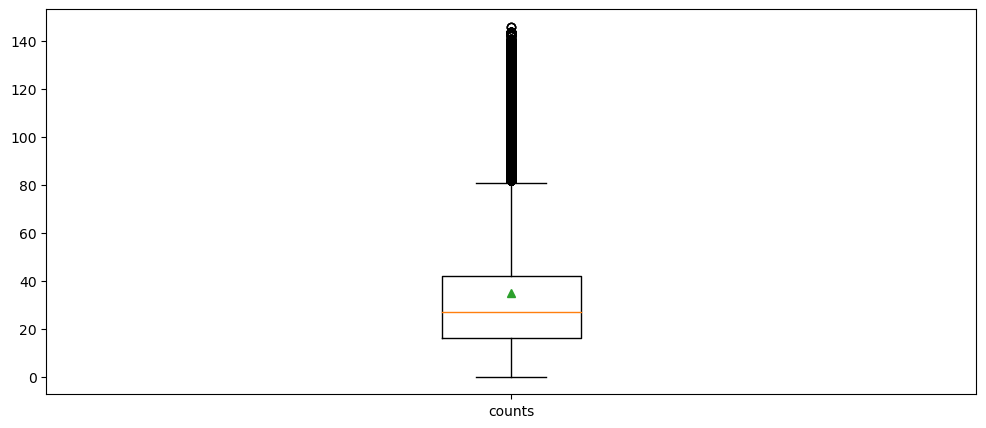

In [15]:
print('리뷰 길이 최대 값: {}'.format(np.max(train_length)))
print('리뷰 길이 최소 값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간 값: {}'.format(np.median(train_length)))

print('리뷰 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25))) # 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75))) # 사분위의 대한 경우는 0~100 스케일로 되어있음

# 박스플롯 생성
# 첫번째 parameter : 여러 분포에 대한 데이터 리스트를 입력
# labels : 입력한 데이터에 대한 라벨
# showmeans : 평균값을 마크함
plt.figure(figsize=(12, 5))
plt.boxplot(train_length,
             labels=['counts'],
             showmeans=True)

# Bert Classifier Model

In [16]:
class BertClassifier(nn.Module):
    # TrnaformerTraining을 True로 하면 BERT 모델까지 학습되며, False로 하면 Transformer위에 Classification Head만 학습됩니다.
    def __init__(self, device, bertTraining=False):
        super(BertClassifier,self).__init__() # nn.Module의 __init__() 변수들을 상속받게 하여 사용할 수 있게 하는 역할 (https://cnu-jinseop.tistory.com/185?category=998353)

        self.device = device
        # https://github.com/monologg/KoELECTRA
        # base model
        self.bert = BertModel.from_pretrained("beomi/kcbert-base") # base 모델 호출

        # True of False를 분류하는 문제이기 때문에 Output을 1개만 내보냅니다.
        self.classificationLayer1 = nn.Linear(768, 1) # 레이어 1층

        self.bertTraining = bertTraining

        self.dropout = nn.Dropout(0.3) # dropout 비율 설정 : 0.3

    def forward(self, bert_input):

        # Bert Model Forward
        if self.bertTraining:
            x = self.bert(input_ids=bert_input['input_ids'], token_type_ids=bert_input['token_type_ids'], attention_mask=bert_input['attention_mask'])
        else:
            with torch.no_grad(): # pytorch의 autograd engine 작동 멈춤 > 더이상 자동으로 gradient 트래킹 안함 > 메모리 사용량 아껴줌
                x = self.bert(input_ids=bert_input['input_ids'], token_type_ids=bert_input['token_type_ids'], attention_mask=bert_input['attention_mask'])
        
        # Bert Model에서 CLS Token의 output만 사용합니다. = x['pooler_output']
        x = F.gelu(x['pooler_output']) # TORCH.NN.FUNCTIONAL.GELU : 원본입력에 원본입력을 Gaussian distribution의 CDF를 통과한 값과 곱해주는 함수
        
        x = self.dropout(x)

        x = self.classificationLayer1(x)
        
        # 최종적인 예측은 0~1사이의 확률값이길 원하니 sigmoid로 공역의 범위를 제한시킵니다.
        x =  torch.sigmoid(x)   # 다중 분류인 경우 SOFTMAX

        return x

* bert_tokenizer (>>> bert_tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base"))




In [17]:
# bert 학습 모델 입력 만들기
bert_input_train_data = [bert_tokenizer(x, max_length=150 ,padding='max_length', truncation=True, return_tensors='pt') for x in train_data]
# max_length : 문장의 토큰 기준 최대 길이 (문장토큰최대길이=150)
# padding='max_length' : 문장의 최대 길이에 맞춰 패딩
# truncation=True : 문장 잘림 허용 옵션
# retrun_tensors="pt" : token을 tensor로 반환

In [18]:
# bert 시험 모델 입력 만들기
bert_input_test_data = [bert_tokenizer(x, max_length=150 ,padding='max_length', truncation=True, return_tensors='pt') for x in test_data]
# max_length : 문장의 토큰 기준 최대 길이 (문장토큰최대길이=150)
# padding='max_length' : 문장의 최대 길이에 맞춰 패딩
# truncation=True : 문장 잘림 허용 옵션
# retrun_tensors="pt" : token을 tensor로 반환

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BertClassifier(device,True).to(device)

loss_function = nn.BCELoss()  # Croess Entropy https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# BCELoss
# 모델의 구조 상에 마지막 Layer가 Sigmoid 혹은 Softmax로 되어 있는 경우 이를 사용함
# (즉, 모델의 출력이 각 라벨에 대한 확률값으로 구성되었을 때 사용 가능함)

optimizer =  torch.optim.Adam(model.parameters(), lr= 2e-5) # optimizer 및 learning rate 설정

SyntaxError: invalid syntax (1866832336.py, line 8)

In [20]:
BATCH_SIZE = 48
EPOCH = 3

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list =[]

for epoch in range(EPOCH):
    train_loss = 0
    train_acc = 0

    # train 진행
    model.train()
    for i in tqdm(range(len(bert_input_train_data)//BATCH_SIZE)):

        batch_input = bert_input_train_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        # BERT 모델에 필요한 input 데이터
        input_ids = torch.tensor([x['input_ids'].flatten().tolist() for x in batch_input]).to(device) # input_ids 데이터 텐서
        token_type = torch.tensor([x['token_type_ids'].flatten().tolist() for x in batch_input]).to(device) # token_type 데이터 텐서
        attention_mask = torch.tensor([x['attention_mask'].flatten().tolist() for x in batch_input]).to(device) # attention_mask 데이터 텐서

        input = {'input_ids':input_ids, 'token_type_ids':token_type, 'attention_mask':attention_mask}

        y_hat = model(input).flatten()
        y_label = train_label[i*BATCH_SIZE:(i+1)*BATCH_SIZE].to(device).float()

        optimizer.zero_grad()    # 이전 미분 값을 없애줘 > 초기화
        loss = loss_function(y_hat, y_label) # loss 연산
        loss.backward()         # 이번 step의 loss로 기울기를 계산해줘 > weight 연산
        optimizer.step()        # 기울기를 가지고 parameter를 바꿔줘 > 업데이트

        train_acc += sum(torch.round(y_hat)==y_label).item()
        train_loss+=loss.item()
        

    # test 진행
    test_acc = 0
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(len(bert_input_test_data)//BATCH_SIZE)):

            batch_input = bert_input_test_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

            input_ids = torch.tensor([x['input_ids'].flatten().tolist() for x in batch_input]).to(device)
            token_type = torch.tensor([x['token_type_ids'].flatten().tolist() for x in batch_input]).to(device)
            attention_mask = torch.tensor([x['attention_mask'].flatten().tolist() for x in batch_input]).to(device)

            input = {'input_ids':input_ids, 'token_type_ids':token_type, 'attention_mask':attention_mask}

            y_hat = model(input).flatten()
            y_label = test_label[i*BATCH_SIZE:(i+1)*BATCH_SIZE].to(device).float()

            loss = loss_function(y_hat, y_label)

            test_acc += sum(torch.round(y_hat)==y_label).item()
            test_loss+=loss.item()

    
    # 결과값 리스트에 할당
    train_acc_list.append(train_acc/len(bert_input_train_data))
    train_loss_list.append(train_loss/len(bert_input_train_data))
    test_acc_list.append(test_acc/len(bert_input_test_data))
    test_loss_list.append(test_loss/len(bert_input_test_data))
    print("Train ACC : ", train_acc/len(bert_input_train_data))
    print("Train Average Loss : ", train_loss/len(bert_input_train_data))
    print("Test ACC : ", test_acc/len(bert_input_test_data))
    print("Test Average Loss : ", test_loss/len(bert_input_test_data))
    print('-'*50)

100%|████████████████████████████████████████████████████████████████████████████| 1041/1041 [2:04:39<00:00,  7.18s/it]


Traini ACC :  0.8751333333333333
Train Average Loss :  0.006070263562003772
Test ACC :  0.89576
Test Average Loss :  0.005208050286918879
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████| 1041/1041 [2:02:15<00:00,  7.05s/it]


Traini ACC :  0.9269333333333334
Train Average Loss :  0.003865644020475447
Test ACC :  0.89816
Test Average Loss :  0.0057066375336796045
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████| 1041/1041 [2:00:40<00:00,  6.96s/it]

Traini ACC :  0.95764
Train Average Loss :  0.0024402243461832404
Test ACC :  0.89178
Test Average Loss :  0.007155018482394517
--------------------------------------------------


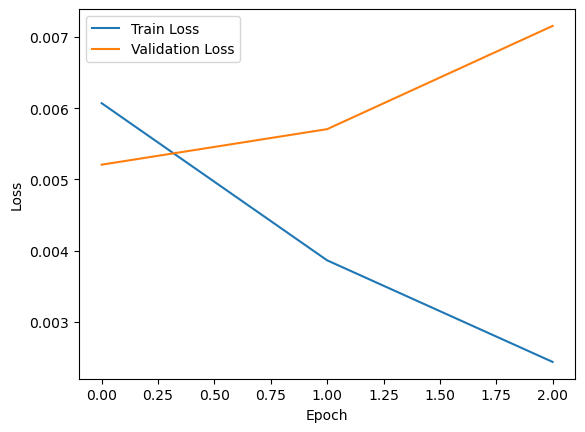

In [21]:
plt.plot(list(range(len(train_loss_list))),train_loss_list, label='Train Loss')
plt.plot(list(range(len(test_loss_list))), test_loss_list, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

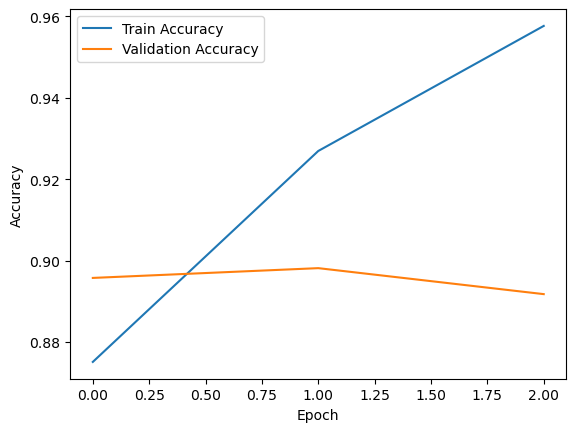

In [22]:
plt.plot(list(range(len(train_acc_list))),train_acc_list, label='Train Accuracy')
plt.plot(list(range(len(test_acc_list))),test_acc_list, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()